**Part 2. AI Agent 활용 프로젝트**

- Chapter 01. 반복하고 수정하는 Agent

    - **📒[실습]** Clip 02-03. Plan & Execute - 스스로 계획하고 실행하는 Agent

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

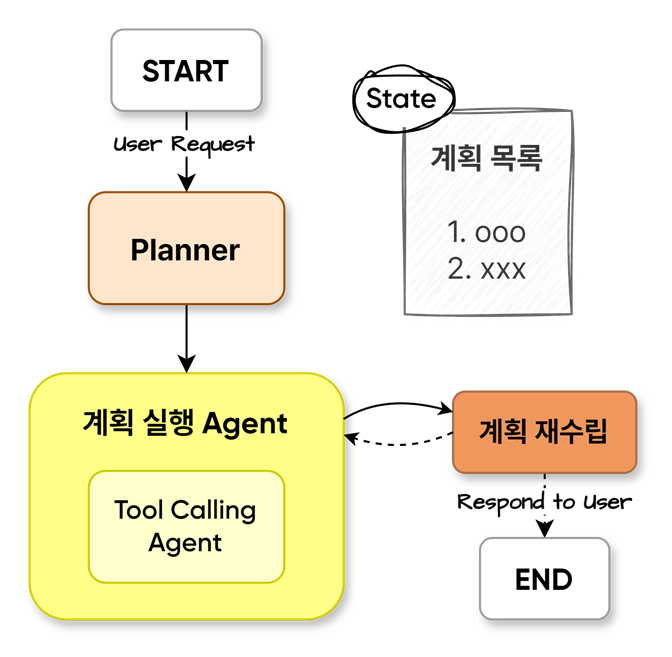

### Step 1. 웹 검색 Agent 만들기

- `create_react_agent` : pre-built ReAct agent

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]

In [3]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")
prompt = "You are a helpful assistant."
plan_executor = create_react_agent(llm, tools, prompt=prompt)

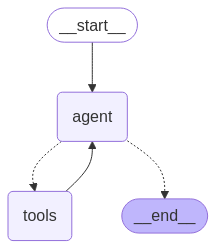

In [ ]:
from IPython.display import Image, display

display(Image(plan_executor.get_graph().draw_mermaid_png()))

In [4]:
plan_executor.invoke({"messages": [("user", "2025년 한국의 최저시급은 얼마입니까?")]})

{'messages': [HumanMessage(content='2025년 한국의 최저시급은 얼마입니까?', additional_kwargs={}, response_metadata={}, id='6b1911e7-183a-4677-adf9-58edf1c86221'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K8iL5nUDib9SZ9yx3eVa527n', 'function': {'arguments': '{"query":"2025년 한국 최저시급"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 99, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BQ7V8npOkz0iaWn4dkpzquQLAr4rL', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-23b55e80-3066-40c5-8d62-e52eaa66805c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2025년 한국 최저시급'}, 'id

### Step 2. Planner 만들기

In [5]:
from pydantic import BaseModel, Field
from typing import List


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
            The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [7]:
plan_result = planner.invoke(
    {
        "messages": [HumanMessage(
            content="2025년 한국에서 개봉한 영화 중 가장 흥행한 영화는 무엇인가요?",
        )]
    }
)

In [8]:
plan_result

Plan(steps=['Identify credible sources of information like film industry databases, box office tracking websites, or news outlets that list box office results for movies released in Korea in 2025.', 'Access the latest available information on these sources to find the list of films released in Korea in 2025.', 'Look specifically for box office earnings data or rankings for these films, focusing on total gross revenue in Korea.', 'From the provided data, identify the film with the highest total gross revenue in Korea for 2025.', 'Record the title of the identified film as the answer to the question of which film was the highest-grossing in Korea in 2025.'])

In [9]:
plan_result.steps

['Identify credible sources of information like film industry databases, box office tracking websites, or news outlets that list box office results for movies released in Korea in 2025.',
 'Access the latest available information on these sources to find the list of films released in Korea in 2025.',
 'Look specifically for box office earnings data or rankings for these films, focusing on total gross revenue in Korea.',
 'From the provided data, identify the film with the highest total gross revenue in Korea for 2025.',
 'Record the title of the identified film as the answer to the question of which film was the highest-grossing in Korea in 2025.']

### Step 3. RePlanner 만들기

In [10]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {input}

    Your original plan was this:
    {plan}

    You have currently done the follow steps:
    {past_steps}

    Update your plan accordingly. 
    If no more steps are needed and you can return to the user, then respond with that. 
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. 
    Do not return previously done steps as part of the plan."""
) # 더 이상 계획 진행이 필요없다면 답변하고, 아직 완료해야하는 단계가 있다면 해당 단계만 plan에 추가하기


In [11]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [12]:
replanner = replanner_prompt | llm.with_structured_output(Act)

### Step 4. Graph 생성하기

In [13]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [14]:
# 계획 생성
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

In [15]:
# 계획 실행
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    
    task = plan[0]
    task_formatted = f"""For the following plan:
    {plan_str}\n\nYou are tasked with executing step {1}, {task}."""

    agent_response = plan_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)], # 실행 완료한 계획과 결과 저장
    }

In [16]:
# 계획 수정
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response): # 답변이 바로 가능한 상태
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

In [17]:
from langgraph.graph import END

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [18]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(PlanExecute)


graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_step)

graph_builder.add_edge(START, "planner")

graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")

graph_builder.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

graph = graph_builder.compile()

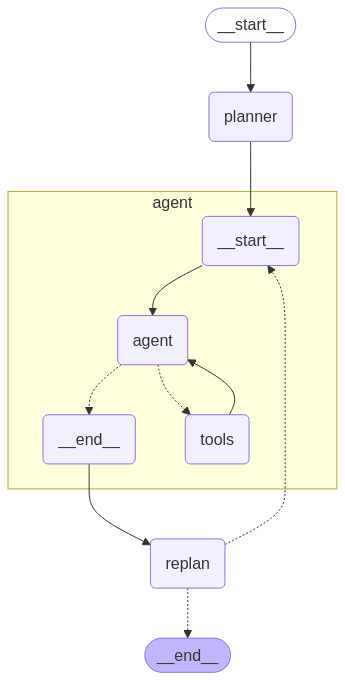

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
config = {"recursion_limit": 50}
inputs = {"input": "2024년 노벨문학상 수상자의 출신국가는 어디인가요?"}
for event in graph.stream(inputs, config=config, stream_mode="values"):
    for k, v in event.items():
        print(k, v)
    print("==========================")

input 2024년 노벨문학상 수상자의 출신국가는 어디인가요?
past_steps []
input 2024년 노벨문학상 수상자의 출신국가는 어디인가요?
plan ['Check for any official announcements or updates on the Nobel Prize website concerning the 2024 Nobel Prize in Literature.', 'Search reputable news sources for reports or articles that mention the 2024 Nobel Prize in Literature awardee.', 'Look for any press releases from the Nobel Prize organization or other authoritative entities regarding the winner.', 'If no information is available for 2024, mention that the data is not yet available.']
past_steps []
input 2024년 노벨문학상 수상자의 출신국가는 어디인가요?
plan ['Check for any official announcements or updates on the Nobel Prize website concerning the 2024 Nobel Prize in Literature.', 'Search reputable news sources for reports or articles that mention the 2024 Nobel Prize in Literature awardee.', 'Look for any press releases from the Nobel Prize organization or other authoritative entities regarding the winner.', 'If no information is available for 2024, mentio